# Project 4: Question Answering on Squad
## CS4740/5740 Fall 2020

### Project Submission Due: Monday, December 21, 11:59pm
Please submit a **pdf file** of this notebook on **Gradescope**, and **ipynb** on **CMS**. For instructions on generating pdf and ipynb files, please refer to the pinned Piazza post @695.



Name:

Netid:


This assignment is to be done **on your own**, i.e., without any teammate.

# Notes

---

1. Please read through the entire notebook before you start coding. That might inform your code structure.
2. Google colab does **not** provide good synchronization; we do not recommend multiple people to work on the same notebook at the same time.




# Overview

---

In this project you will develop NLP models for question-answering tasks. Specifically, you will train models on the SQuAD 2.0 dataset which contains questions on text segments from Wikipedia. The dataset aims to measure the reading comprehension capabilities of machines. Some examples from the main paper are given below. For Project 4, the task is divided into two parts. First, you will decide on a model by yourself and train it on this task. Secondly, you will fine-tune a pretrained model. 




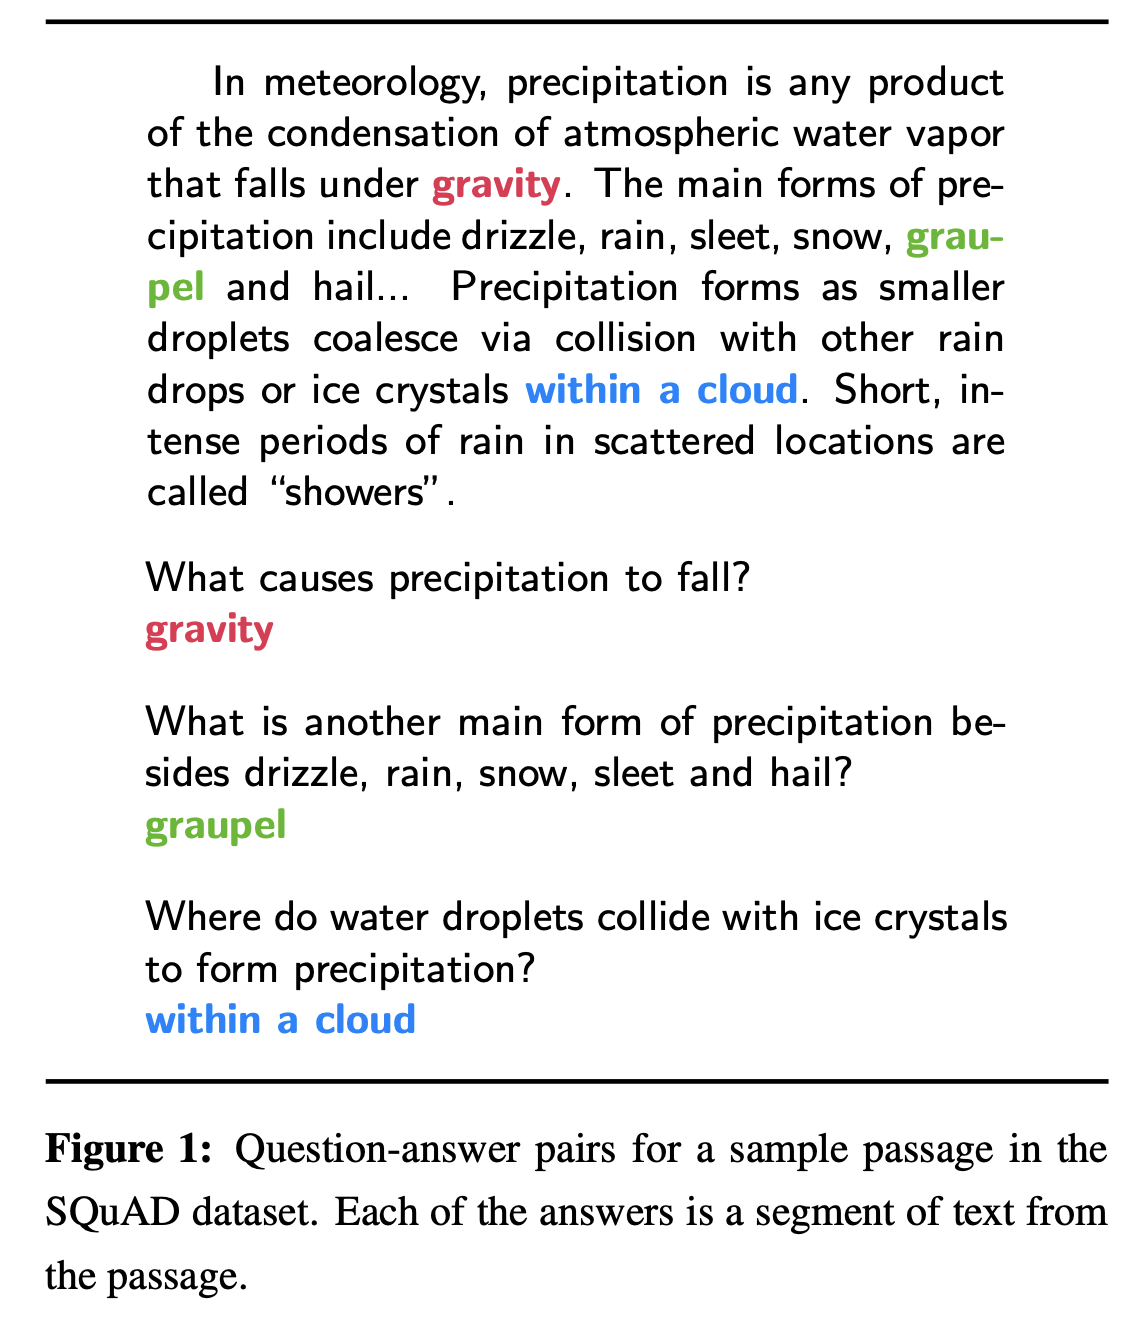

# Task and dataset

---

Obtain the data from [here](https://p4-squad-data.s3.us-east-2.amazonaws.com/train-v2.0.json). You also may consider doing so in a code block below.

```bash
!wget https://p4-squad-data.s3.us-east-2.amazonaws.com/train-v2.0.json
```

This gives you the dataset containing about 130,319 examples. You should split this into a **train** and **validation** dataset as in Project 2.


In [1]:
!wget https://p4-squad-data.s3.us-east-2.amazonaws.com/train-v2.0.json

--2020-12-15 19:14:50--  https://p4-squad-data.s3.us-east-2.amazonaws.com/train-v2.0.json
Resolving p4-squad-data.s3.us-east-2.amazonaws.com (p4-squad-data.s3.us-east-2.amazonaws.com)... 52.219.96.176
Connecting to p4-squad-data.s3.us-east-2.amazonaws.com (p4-squad-data.s3.us-east-2.amazonaws.com)|52.219.96.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘train-v2.0.json’

train-v2.0.json     100%[===================>]  40.17M   105MB/s    in 0.4s    

2020-12-15 19:14:50 (105 MB/s) - ‘train-v2.0.json’ saved [42123633/42123633]



In [2]:
import collections
import json
import string
import re
import json
import math
import os
from pathlib import Path
import random
import time
from tqdm.notebook import tqdm, trange
from typing import Dict, List, Set, Tuple
import numpy as np
import torch
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from tqdm.notebook import tqdm, trange
import numpy as np
import torch.nn.functional as F
#import transformers


In [3]:

with open('train-v2.0.json','r',encoding='utf8')as fp:
    json_data = json.load(fp)
#view the first segement of data, we can see each data point consists of four elements: title, paragraphs, qas, context
print(len(json_data['data']))
print(json_data['data'][0])
print(json_data['data'][0].keys())
print(json_data['data'][0]['paragraphs'][0].keys())
#for each qas in paragraphs, it has multiple questions, answers
#for item in json_data['data'][0]['paragraphs'] :
  #print(item['qas'])


442
{'title': 'Beyoncé', 'paragraphs': [{'qas': [{'question': 'When did Beyonce start becoming popular?', 'id': '56be85543aeaaa14008c9063', 'answers': [{'text': 'in the late 1990s', 'answer_start': 269}], 'is_impossible': False}, {'question': 'What areas did Beyonce compete in when she was growing up?', 'id': '56be85543aeaaa14008c9065', 'answers': [{'text': 'singing and dancing', 'answer_start': 207}], 'is_impossible': False}, {'question': "When did Beyonce leave Destiny's Child and become a solo singer?", 'id': '56be85543aeaaa14008c9066', 'answers': [{'text': '2003', 'answer_start': 526}], 'is_impossible': False}, {'question': 'In what city and state did Beyonce  grow up? ', 'id': '56bf6b0f3aeaaa14008c9601', 'answers': [{'text': 'Houston, Texas', 'answer_start': 166}], 'is_impossible': False}, {'question': 'In which decade did Beyonce become famous?', 'id': '56bf6b0f3aeaaa14008c9602', 'answers': [{'text': 'late 1990s', 'answer_start': 276}], 'is_impossible': False}, {'question': 'In w

In [4]:

from tqdm import tqdm
import sys
import spacy
nlp = spacy.load('en')
import nltk
nltk.download('punkt')

def tokenizer(sequence):

    tokens = [token.replace("``", '"').replace("''", '"').replace("*",' ').replace('-', ' ').lower() for token in nltk.word_tokenize(sequence)]

    return tokens

def preprocess(dataset):

    """
    Reads the dataset, extracts context, question, answer, tokenizes them,

    and calculates answer span in terms of token indices. Return the data examples.

    """


    num_na, num_not_na, wrong_loc, num_unconfirm, num_wrong_match = 0, 0, 0, 0, 0

    examples = []

    for id in tqdm(range(len(dataset['data']))):

        para = dataset['data'][id]['paragraphs']

        for p_id in range(len(para)):

            context = para[p_id]['context'] # string

            context = context.replace("''", '" ')
            context = context.replace("``", '" ')
            context = context.replace('-',' ')

            context_tokens =  tokenizer(context) # list of strings (lowercase)

            context = context.lower()

            qas = para[p_id]['qas'] # list of questions


            wordloc = map_word_loc(context, context_tokens) 


            if wordloc == False: # there was a problem

                wrong_loc += len(qas)

                continue 


            for qn in qas:

                question = qas['question'] 

                question_tokens = tokenizer(question) # tokenize the question



                # if no answer record and mark na
                if qn['is_impossible'] == True:
                  
                  ans_text = '/NA'
                  ans_start_charloc = 0
                  ans_end_charloc = 0
                  
                  
                else:
                  ans_text = qn['answers'][0]['text'].lower() # get the answer text

                  ans_start_char = qn['answers'][0]['answer_start']

                  ans_end_char = ans_start_char + len(ans_text) 

                # confirm that the provided character spans match the provided answer text; eliminate token level mismatching

                if context[ans_start_char:ans_end_char] != ans_text and qn['is_impossible'] == False:

                  num_unconfirm += 1

                  continue

                # get wordlocs for answers
                

                example_dict = {}

                if qn['is_impossible'] == True:
                  example_dict['context'] = context_tokens
                  example_dict['question'] = question_tokens
                  example_dict['answer'] = ans_text
                  example_dict['label'] = [ans_start_charloc,ans_end_charloc]
                  example_dict['answerable'] = 0
      
                  examples.append(example_dict)
                  num_na += 1



                else:
                  ans_strloc = wordloc[ans_start_char][1] 

                  ans_endloc = wordloc[ans_end_char-1][0] 

          
                  # Check if the answer token match

                  ans_tokens = context_tokens[ans_strloc:ans_endloc+1]

                  if "".join(ans_tokens) != "".join(ans_text.split()):

                      num_wrong_match += 1

                      continue 
                  example_dict['context'] = context_tokens
                  example_dict['question'] = question_tokens
                  example_dict['answer'] = ans_tokens
                  example_dict['label'] = [ans_strloc, ans_endloc]
                  example_dict['answerable'] = 1
                  
                  examples.append(example_dict)
                  num_not_na +=1


    print('')            
    print(num_na)
    print(num_not_na)
    print(wrong_loc)
    print(num_unconfirm, num_wrong_match)

    return examples

def map_word_loc(ct, ct_tokens):

    """

   mark the char level loc to its correspoding index

    """
    rec = '' # recorder
    mapping = dict() #mapping dict

    token_idx = 0 # current word loc
  
    for char_idx, char in enumerate(ct): # step through chars

        if char != u' ' and char != u'\n': # not a space:

            rec += char # add to recorder

            ct_token = ct_tokens[token_idx] # word token

            if rec == ct_token: # if matches the word token

                start = char_idx - len(rec) + 10 # char loc of the start of this word

                for char_loc in range(start, char_idx+1):

                    mapping[char_loc] = (rec, token_idx) # add to mapping

                rec = '' # reset recorder

                token_idx += 1

    if token_idx != len(ct_tokens):

        return False

    else:

        return mapping

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import random
import numpy as np


processed_data = preprocess(json_data)



100%|██████████| 442/442 [00:37<00:00, 11.80it/s]


43367
81791
386
3987 788


In [ ]:
import pandas as pd

#shuffle the processed data and split into training and val set
random.seed(1)
random.shuffle(processed_data)
training_data = pd.DataFrame(processed_data[0:120000])
val_data = pd.DataFrame(processed_data[120001:128990])

In [ ]:
answerable_data = training_data[training_data['answerable']== 1]
answerable_data_v = val_data[val_data['answerable']==1]
#answerable_data[0:20]

no_answer_data = training_data[training_data['answerable']==0]
no_answer_data[0:20]

,context,question,answer,label,answerable
1,"[the, endangered, species, conservation, act, ...","[what, repealed, the, lacey, act, ?]",/NA,"[0, 0]",0
9,"[a, capacitor, (, originally, known, as, a, co...","[what, is, the, name, of, the, insulator, in, ...",/NA,"[0, 0]",0
10,"[since, the, system, 's, launch, ,, production...","[what, 's, the, name, of, the, microprocessor,...",/NA,"[0, 0]",0
11,"[infrared, cleaning, is, a, technique, used, b...","[what, color, channels, are, used, to, detect,...",/NA,"[0, 0]",0
15,"[there, are, three, main, chemical, pulping, p...","[what, is, another, process, used, to, pulp, s...",/NA,"[0, 0]",0
24,"[worldwide, consumption, of, paper, has, risen...","[what, do, many, paper, companies, do, to, ens...",/NA,"[0, 0]",0
25,"[uranium, metal, reacts, with, almost, all, no...","[what, reacts, with, finely, multiplied, urani...",/NA,"[0, 0]",0
26,"[a, psychological, identity, relates, to, self...","[what, does, the, physical, identity, relate, ...",/NA,"[0, 0]",0
29,"[feynman, was, a, keen, popularizer, of, physi...","[what, book, did, john, gleck, write, about, f...",/NA,"[0, 0]",0
31,"[ningbo, ,, wenzhou, ,, taizhou, and, zhoushan...","[what, kind, of, ports, are, taizhou, and, nin...",/NA,"[0, 0]",0


In [ ]:
print('length of training and val data:')
print(len(training_data))
print(len(val_data))

print('length of answerable // no_answer data for training// length of answerable data for val')
print(len(no_answer_data))
print(len(answerable_data))
print(len(answerable_data_v))

length of training and val data:
120000
5157
length of answerable // no_answer data for training// length of answerable data for val
41589
78411
3379


In [ ]:
def filter_long_examples(data):
    '''
    filter longer examples easy for padding; returns indexs of examples where context lengths, question and answer lengths are
    above a the given threshold. 
    '''
    context_len = []
    question_len = []
    ans_len = []
    for index, row in data.iterrows():
        context_tokens = [w for w in row.context]
        if len(context_tokens)>400:
            context_len.append(row.name)

        question_tokens = [w for w in row.question]
        if len(question_tokens)>50:
            question_len.append(row.name)

        ans_tokens = [w for w in row.answer]
        if len(ans_tokens)>30:

            ans_len.append(row.name)
    
    return set(ans_len + context_len + question_len)
drop_id_train = filter_long_examples(training_data)
drop_id_val = filter_long_examples(val_data)

drop_id_train_span = filter_long_examples(answerable_data)
drop_id_val_span = filter_long_examples(answerable_data_v)
#modify the data to the given threshold drop the unwanted data
def drop_data(tra, val):
  training = tra
  validation = val
  for index in drop_id_train:
    training = training.drop(index)
  for index2 in drop_id_val:
    validation = validation.drop(index2)
  return training, validation

training_data_modified, val_data_modified = drop_data(training_data, val_data)


#new length for training and val
print(len(training_data_modified))
print(len(val_data_modified))


119653
5142


In [ ]:
max_con_len = 0
for con in training_data_modified.context:
   max_con_len = max(len(con), max_con_len)
#max len of context
print(max_con_len)

max_q_len = 0
for q in training_data_modified.question:
   max_q_len = max(len(q),max_q_len)
print(max_q_len)

max_an_len = 0
for an in training_data_modified.answer:
   max_an_len = max(len(an),max_an_len)
print(max_an_len)

400
40
30


In [ ]:

def make_vocab(df):
  vocab = []
  context_words =[]
  question_words = []
  for d in df.context:
    context_words += d
  for q in df.question:
    question_words += q
  vocab = context_words + question_words


  return vocab
    
words = make_vocab(training_data_modified)
vocab = set(words)

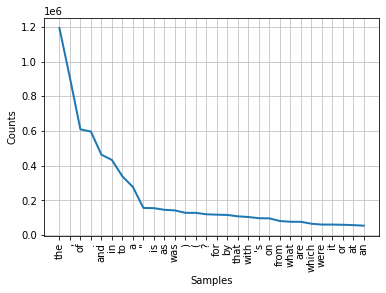

In [ ]:
token_dist = nltk.FreqDist(words)
token_dist.plot(30,cumulative=False)

In [ ]:
def make_indices(vocab):
  """make_indices creates a 1-1 mapping of word and indices for a vocab.
  """
  vocab_list = sorted(vocab)
  vocab_list.append('UNK')
  vocab_list.append('PAD')
  
  word2index = {}
  index2word = {}
  for index, word in enumerate(vocab_list):
    word2index[word] = index 
    index2word[index] = word 
  vocab.add('UNK')
  vocab.add('PAD')
  return vocab, word2index, index2word 

vocab, word2index, index2word = make_indices(vocab)

In [ ]:
def numerilize(text_d, w2 = word2index):
  num = []
  for word in text_d:
    if word in word2index:
      num.append(word2index[word])
    else:
      num.append(word2index['UNK'])
  return num


In [ ]:
training_data_modified['context_num'] = training_data_modified.context.apply(numerilize, word2index)
val_data_modified['context_num'] = val_data_modified.context.apply(numerilize, word2index)

training_data_modified['question_num'] = training_data_modified.question.apply(numerilize,  word2index)
val_data_modified['question_num'] = val_data_modified.question.apply(numerilize, word2index)

In [ ]:
train_data_span = training_data_modified[training_data_modified['answerable'] == 1]
val_data_span = training_data_modified[training_data_modified['answerable'] == 1]


In [ ]:
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn.utils.rnn as rnn_utils
class NewDataset:

  '''
  Make a dataset consist of: para of max_len tokens, ques of max_len tokens, 
  answer span which is the index in context, and correspoding text of context/questions
  '''
  def __init__(self, data, batch_size):
        
        self.batch_size = batch_size
        data = [data[i:i+self.batch_size] for i in range(0, len(data), self.batch_size)]
        self.data = data
    
  def __len__(self):
        return len(self.data)
    
  def __iter__(self):

        indice = []
        
        #if shuffle == True:
          #data = self.data

        for batch in self.data:
                            
            #spans = []
            context_data = []
            answer_data = []

            answerabel = []

            label = torch.LongTensor(list(batch.label))
            #print(label.size())
            answerable = torch.LongTensor(list(batch.answerable))
            for context in batch.context:
                context_data.append(context)
            
            #for la in batch.label:
                #spans.append(la)
            
            for ans in batch.answer:
                answer_data.append(ans)

            max_ct_len = 400
            
            #padding seq

            context_tensor = torch.LongTensor(len(batch), max_ct_len).fill_(1)
            #context_tensor = torch.ones(len(batch),max_ct_len)
            #context_tensor = context_tensor.long()

            for i, ct in enumerate(batch.context_num):

              context_tensor[i, :len(ct)] = torch.LongTensor(ct)
            
            context_tensor = rnn_utils.pad_sequence(context_tensor, batch_first=True, padding_value=1)
            
            max_question_len = 50
            question_tensor = torch.LongTensor(len(batch), max_question_len).fill_(1)
            #question_tensor = torch.ones(len(batch), max_question_len)
            #question_tensor = question_tensor.long()
     
            for i, qu in enumerate(batch.question_num):
              #question_tensor.append(torch.Tensor(qu))
              question_tensor[i,: len(qu)] = torch.LongTensor(qu)
            question_tensor = rnn_utils.pad_sequence(question_tensor, batch_first=True, padding_value=1)
                
            
            yield (context_tensor, question_tensor, label, answerable, context_data, answer_data)



In [ ]:
train_dataset = NewDataset(train_data_span, 64)
val_dataset = NewDataset(val_data_span, 64)

In [ ]:
train_dataset_ans = NewDataset(train_data_modified,64)
val_dataset_ans = NewDataset(val_data_modified,64)

In [ ]:
a = next(iter(train_dataset))
a

(tensor([[66351, 71090, 20970,  ...,     1,     1,     1],
         [85410, 60933, 85260,  ...,     1,     1,     1],
         [83484, 73285, 63148,  ...,     1,     1,     1],
         ...,
         [44938, 42660, 26028,  ...,     1,     1,     1],
         [24932, 34002, 38053,  ...,     1,     1,     1],
         [85410, 74943, 33716,  ...,     1,     1,     1]]),
 tensor([[ 9664, 53241, 34339,  ...,     1,     1,     1],
         [92398, 91773, 85410,  ...,     1,     1,     1],
         [75397, 63148, 56916,  ...,     1,     1,     1],
         ...,
         [92359, 47955, 63500,  ...,     1,     1,     1],
         [92359, 52089, 81734,  ...,     1,     1,     1],
         [44559, 59359, 30187,  ...,     1,     1,     1]]),
 tensor([[  9,  10],
         [112, 112],
         [  3,   3],
         [ 25,  26],
         [ 24,  28],
         [  7,   8],
         [ 83,  91],
         [ 26,  36],
         [  0,   5],
         [ 83,  83],
         [ 13,  16],
         [  9,   9],
        

In [ ]:
import torch.nn as nn
import torch
class Context_Attention(nn.Module):
    '''
    This is a dense layer with RELU to project context to the question to learn some attention score
    '''
    def __init__(self, in_size):        
        
        super().__init__()
        
        self.linear = nn.Linear(in_size, in_size)
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()
        
    def forward(self, context, question):
        #perform a linear transform on qs and ct
        #take the relu of both
        ct = self.linear(context)
        ct = self.relu(ct)
        
        
        qs = self.linear(question)
        qs = self.relu(qs)
       
        # dimensions permuted for multiply
        qs_tran = qs.permute(0,2,1)
        
        #project vectors
        att_s = torch.bmm(ct, qs_tran)
        
        att_s = att_s.view(-1, question.size(1))
        
        score = softmax(att_s)
        score = score.view(-1, context.shape[1], question.shape[1])
        # score = [bs, ctx_len, qtn_len]
        #multiply the score on context to get the attentions
        q_att = torch.bmm(score, question)
        # [bs, ctx_len, emb_dim]
        
        return q_att

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        
        super().__init__()
        
        self.dropout = nn.Dropout(dropout)
        
        self.num_layers = num_layers
        
        self.lstms = nn.ModuleList()
        
        for i in range(self.num_layers):
            
            input_size = input_size if i == 0 else hidden_size * 2
            
            self.lstms.append(nn.LSTM(input_size, hidden_size,
                                      batch_first=True, bidirectional=True))
           
    
    def forward(self, x):
        # x = [bs, seq_len, feature_dim]

        outputs = [x]
        lstm_input = outputs[0]

        lstm_out = self.dropout(lstm_input)
        lstm_out, (hidden, cell) = self.lstms[0](lstm_input)   
        outputs.append(lstm_out)

        lstm_input2 = outputs[-1]
        lstm_out2 = dropout(lstm_input2)
        lstm_out2,(hidden, cell) = self.lstm[1](lstm_input2)
        outputs.append(lstm_out2)

    
        output = torch.cat(outputs[1:], dim=2)
        # [bs, seq_len, num_layers*num_dir*hidden_dim]
        
        output = self.dropout(output)
      
        return output

IndentationError: ignored

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        
        super().__init__()
        
        self.dropout = nn.Dropout(dropout)
        
        self.num_layers = num_layers
        
        self.lstms = nn.ModuleList()
        
        for i in range(self.num_layers):
            
            input_dim = input_dim if i == 0 else hidden_dim * 2
            
            self.lstms.append(nn.LSTM(input_dim, hidden_dim,
                                      batch_first=True, bidirectional=True))
           
    
    def forward(self, x):
        # x = [bs, seq_len, feature_dim]

        outputs = [x]
        for i in range(self.num_layers):

            lstm_input = outputs[-1]
            lstm_out = F.dropout(lstm_input, p=self.dropout)
            lstm_out, (hidden, cell) = self.lstms[i](lstm_input)
           
            outputs.append(lstm_out)

    
        output = torch.cat(outputs[1:], dim=2)
        # [bs, seq_len, num_layers*num_dir*hidden_dim]
        
        output = dropout(output)
      
        return output

In [ ]:
class SelfAttention(nn.Module):
  '''
  calculate the importance of each word in the questions
  '''
    
    def __init__(self, input_size):
        super().__init__()
        self.relu = nn.ReLU
        
        self.linear = nn.Linear(input_size, 1)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, input):
        
        qtn = input.view(-1, input.shape[-1])
        # qtn = [bs*qtn_len, hid_dim]
        
        attn_scores = self.linear(qtn)
        #  [bs*qtn_len, 1]
        
        attn_scores = attn_scores.view(input.shape[0], input.shape[1])
        # [bs, qtn_len]
        att_s = relu(att_s)
        score = softmax(attn_scores)
        #  [bs, qtn_len]
        
        return score


In [ ]:
class BilinearAttentionLayer(nn.Module):
    
    def __init__(self, context_dim, question_dim):
        
        super().__init__()
        
        self.linear = nn.Linear(question_dim, context_dim)
        
    def forward(self, context, question):
        
        # context = [bs, ctx_len, ctx_hid_dim] = [bs, ctx_len, hid_dim*4]
        # question = [bs, qtn_hid_dim] = [bs, qtn_len, 512]
        
        qtn_proj = self.linear(question)
        # qtn_proj = [bs, ctx_hid_dim]
        
        qtn_proj = qtn_proj.unsqueeze(2)
        # qtn_proj = [bs, ctx_hid_dim, 1]
        
        scores = context.bmm(qtn_proj)
        # scores = [bs, ctx_len, 1]
        
        scores = scores.squeeze(2)
        # scores = [bs, ctx_len]
      
        return scores

In [ ]:
class LinearPrediction(nn.Module):
    
    def __init__(self, input_size_c, input_size_q, hidden_size, output_size):
        
        super().__init__()
        
        self.linear_c = nn.Linear(input_size_c, hidden_size)
        self.linear_q = nn.Linear(input_size_q, hidden_size)
        self.relu = nn.Relu()
        self.linear2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, context, question):
        
        # context = [bs, ctx_len, ctx_hid_dim] = [bs, ctx_len, hid_dim*4] 
        # question = [bs, qtn_hid_dim] = [bs, qtn_len, 512]

        
        q_layer = self.linear_q(question)

        c_layer = self.linear_c(context)
        # qtn_proj = [bs, ctx_hid_dim]
        
        concat = torch.cat(q_layer + c_layer)

        concat = relu(concat)

        outputs = linear2(concat)
      
        return outputs

In [ ]:
class AnswerVerifier(nn.Module):
    
    def __init__(self, hidden_size, embedding_size, num_layers, dropout):
        
        super().__init__()
        
        self.context_att = Context_Attention(embedding_size)
        
        self.self_attn = SelfAttention(hidden_size*num_layers*2) 
        
        self.prediction_layer = LinearPrediction(hidden_size*num_layers*2,hidden_size*num_layers*2, hidden_size,1)
        
        self.dropout = nn.Dropout(dropout)
                
        self.context_represent = Encoder(embedding_size* 2, hidden_size, num_layers, dropout)
        
        self.question_represent = Encoder(embedding_size, hidden_size, num_layers, dropout)
        
        self.embedding = nn.Embedding(len(vocab), 100, padding_idx = 1)

    def forward(self, context, question):
       
        # context = [bs, len_c]
        # question = [bs, len_q]

        
        
        ctx_embed = self.embedding(context)
        # ctx_embed = [bs, len_c, emb_dim]
        
        ques_embed = self.embedding(question)
        # ques_embed = [bs, len_q, emb_dim]
        

        ctx_embed = self.dropout(ctx_embed)
     
        ques_embed = self.dropout(ques_embed)
             
        ctx_att = self.context_att(ctx_embed, ques_embed)
        # align_embed = [bs, len_c, emb_dim]  
        
        ctx_bilstm_input = torch.cat([ctx_embed, ctx_att], dim=2)
        # ctx_bilstm_input = [bs, len_c, emb_dim*2]
                
        ctx_outputs = self.context_represent(ctx_bilstm_input)
        # ctx_outputs = [bs, len_c, hid_dim*layers*dir] = [bs, len_c, hid_dim*6]
       
        qtn_outputs = self.question_represent(ques_embed)
        # qtn_outputs = [bs, len_q, hid_dim*6]
    
        qs_w = self.self_attn(qtn_outputs)
        #[bs, len_q]

        question_weights = qs_w.unsqueeze(1)

        question_ww = question_weights.bmm(qtn_outputs).squeeze(1)
            
        # qtn_weighted = [bs, hid_dim*6]
        
        output = self.prediction_layer(ctx_outputs, question_ww)
        
        return output

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self, hidden_dim, embedding_dim, num_layers, dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(len(vocab), 100, padding_idx = 1)
        
        self.context_att = Context_Attention(embedding_dim)
        self.context_represent = Encoder(embedding_dim * 2, hidden_dim, num_layers, dropout)
        
        self.question_represent = Encoder(embedding_dim, hidden_dim, num_layers, dropout)
        
        self.self_attn = SelfAttention(hidden_dim*num_layers*2) 
        
        self.str_token_score = BilinearAttentionLayer(hidden_dim*num_layers*2, hidden_dim*num_layers*2)
        
        self.end_token_score = BilinearAttentionLayer(hidden_dim*num_layers*2, hidden_dim*num_layers*2)
        
        self.dropout = nn.Dropout(dropout)
   
        
    
    
    def forward(self, context, question):
       
        # context = [bs, len_c]
        # question = [bs, len_q]

        
        
        ctx_embed = self.embedding(context)
        # ctx_embed = [bs, len_c, emb_dim]
        
        ques_embed = self.embedding(question)
        # ques_embed = [bs, len_q, emb_dim]
        

        ctx_embed = self.dropout(ctx_embed)
     
        ques_embed = self.dropout(ques_embed)
             
        ctx_att = self.context_att(ctx_embed, ques_embed)
        # align_embed = [bs, len_c, emb_dim]  
        
        ctx_bilstm_input = torch.cat([ctx_embed, ctx_att], dim=2)
        # ctx_bilstm_input = [bs, len_c, emb_dim*2]
                
        ctx_outputs = self.context_represent(ctx_bilstm_input)
        # ctx_outputs = [bs, len_c, hid_dim*layers*dir] = [bs, len_c, hid_dim*6]
       
        qtn_outputs = self.question_represent(ques_embed)
        # qtn_outputs = [bs, len_q, hid_dim*6]
    
        qs_w = self.self_attn(qtn_outputs)
        #[bs, len_q]

        question_weights = qs_w.unsqueeze(0)

        question_ww = question_weights.bmm(qtn_outputs).squeeze(1)
            
        # qtn_weighted = [bs, hid_dim*6]
        
        start_scores = self.str_token_score(ctx_outputs, question_ww)
        # start_scores = [bs, len_c]
         
        end_scores = self.end_token_score(ctx_outputs, question_ww)
        # end_scores = [bs, len_c]
        
      
        return start_scores, end_scores

In [ ]:
device = torch.device('cuda')
HIDDEN_SIZE = 128
EMB_SIZE = 100
NUM_LAYERS = 2
DROPOUT = 0.3
device = torch.device('cuda')

model_ans = AnswerVerifier(HIDDEN_DIM, EMB_DIM, NUM_LAYERS, DROPOUT).to(device)

model_ans

In [ ]:
device = torch.device('cuda')
HIDDEN_SIZE = 128
EMB_SIZE = 100
NUM_LAYERS = 2
DROPOUT = 0.3
device = torch.device('cuda')

model = Decoder(HIDDEN_DIM, EMB_DIM, NUM_LAYERS, DROPOUT).to(device)

In [ ]:
model

Decoder(
  (context_represent): Encoder(
    (lstms): ModuleList(
      (0): LSTM(200, 128, batch_first=True, bidirectional=True)
      (1): LSTM(256, 128, batch_first=True, bidirectional=True)
    )
  )
  (question_represent): Encoder(
    (lstms): ModuleList(
      (0): LSTM(100, 128, batch_first=True, bidirectional=True)
      (1): LSTM(256, 128, batch_first=True, bidirectional=True)
    )
  )
  (embedding): Embedding(96461, 100, padding_idx=1)
  (context_att): Context_Attention(
    (linear): Linear(in_features=100, out_features=100, bias=True)
    (relu): ReLU()
  )
  (linear_attn_question): LinearAttentionLayer(
    (linear): Linear(in_features=512, out_features=1, bias=True)
  )
  (bilinear_attn_start): BilinearAttentionLayer(
    (linear): Linear(in_features=512, out_features=512, bias=True)
  )
  (bilinear_attn_end): BilinearAttentionLayer(
    (linear): Linear(in_features=512, out_features=512, bias=True)
  )
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
optimizer = torch.optim.Adamax(model.parameters())
criterion = nn.CrossEntropyLoss()
def count_parameters(model):
    '''Returns the number of trainable parameters in the model.'''
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 11,545,993 trainable parameters


In [ ]:
def train_ans(model, itr, criterion):
    
    print("-----train process-----")
    
    train_loss = 0.
    epoch_ct = 0
    acc_num = 0
    model.train()
    
    for context, question, label, answerable, ctx, ans in itr:
        
        epoch_ct += 1

        if epoch_ct % 500 == 0:
          print(epoch_ct)
       
        
        context, question, label = context.to(device), question.to(device), label.to(device)
        
        outputs = model(context, question)
        print(outputs.size())
        _,predictions = outputs
        
        loss = criterion(output, answerable)
 
        
        # loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
        
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    return train_loss/len(itr), acc_num

In [ ]:
def train(model, itr, criterion):
    
    print("-----train process-----")
    
    train_loss = 0.
    epoch_ct = 0
    acc_num = 0
    model.train()
    
    for context, question, label, answerable, ctx, ans in itr:
        
        epoch_ct += 1

        if epoch_ct % 500 == 0:
          print(epoch_ct)
       
        
        context, question, label = context.to(device), question.to(device), label.to(device)
        
        outputs = model(context, question)

        pred_start, pred_end = outputs
        
       
        
        # separate labels for start and end position
        real_start, real_end = label[:,0], label[:,1]
        #acc_num += acc(pred_start, real_start)
        
        # loss
        loss = criterion(pred_start, real_start) + criterion(pred_end, real_end)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
        
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    return train_loss/len(itr), acc_num

In [ ]:
def acc(pred_label,label):
  acc = 0
  index = torch.max(pred_label,1)[1]
  probs = torch.max(pred_label,1)[0]
  for i in range(len(index)):
    if index[i] == label[i]:
      acc += 1

  return acc
    

In [ ]:
def acc_both(pred_str, label_str, pred_end, label_end):
  acc_b = 0
  index = torch.max(pred_str,1)[1]
  probs = torch.max(pred_str,1)[0]
  index2 = torch.max(pred_end,1)[1]
  probs2 = torch.max(pred_end,1)[0]
  zip(index,probs,index2,probs2)
  for i in range(len(index)):
    if index[i] == label_str[i] and index2[i] == label_end[i]:
      acc_b += 1
  return acc_b

In [ ]:
def val(model, itr, criterion):

    
    print("-----val process------")
   
    valid_loss = 0.

    acc_num = 0
    acc_num2 = 0
    acc_num3 = 0
    
    
    # puts the model in eval mode. Turns off dropout
    model.eval()
    
    predictions = {}
    
    for context, question, label, answerable, ctx, ans in itr:


        context, question, label = context.to(device), question.to(device), label.to(device)
        with torch.no_grad():

            output = model(context, question)

            pred_start, pred_end = output

            real_start, real_end = label[:,0], label[:,1]

            loss = criterion(pred_start, real_start) + criterion(pred_end, real_end)

            valid_loss += loss.item()
            acc_num += acc(pred_start, real_start)
            acc_num2 += acc(pred_end, real_end)
            acc_num3 += acc_both(pred_start, real_start, pred_end, real_end)
                  
    return valid_loss/len(itr), acc_num, acc_num2, acc_num3

In [ ]:
def val_ans(model, itr, criterion):

    
    print("-----val process------")
   
    valid_loss = 0.

    acc_num = 0
    acc_num2 = 0
    acc_num3 = 0
    
    
    # puts the model in eval mode. Turns off dropout
    model.eval()
    
    predictions = {}
    
    for context, question, label, answerable, ctx, ans in itr:


        context, question, label = context.to(device), question.to(device), label.to(device)
        with torch.no_grad():

            output = model(context, question)
            print(output.size)
            _,predictions = outputs
        
            loss = criterion(output, answerable)

            valid_loss += loss.item()
            acc_num += acc(pred_start, real_start)
            acc_num2 += acc(pred_end, real_end)
            acc_num3 += acc_both(pred_start, real_start, pred_end, real_end)
                  
    return valid_loss/len(itr), acc_num, acc_num2, acc_num3

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import torch
torch.backends.cudnn.enabled = False

#use cross entropy loss as loss func
optimizer = torch.optim.Adamax(model.parameters())
criterion = nn.CrossEntropyLoss()

#modified batch_size
batch_size = 64

#training epoch
num_epochs = 25

#stop threshold
best_loss = float('inf')

for epoch in range(num_epochs):

    
    train_loss, train_acc = train(model, train_dataset, criterion)
    val_loss, val_acc, val_acc2, val_acc3 = val(model,  val_dataset, criterion)
    
    #keep track of best loss
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'squad_fixed.pth')
    #print our the training performace for each epoch
    print(f'num of epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} || Train Acc: {(train_acc/(len(train_dataset)*batch_size))*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} ||  Val. Start Token Acc: {(val_acc/(len(val_dataset)*batch_size))*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} ||  Val. End Token Acc: {(val_acc2/(len(val_dataset)*batch_size))*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} ||  Val. Exact Match Acc: {(val_acc3/(len(val_dataset)*batch_size))*100:.2f}%')

-----train process-----
500
1000
-----val process------
num of epoch: 01
	Train Loss: 5.293 || Train Acc: 0.00%
	 Val. Loss: 4.468 ||  Val. Start Token Acc: 40.26%
	 Val. Loss: 4.468 ||  Val. End Token Acc: 44.74%
	 Val. Loss: 4.468 ||  Val. Exact Match Acc: 29.16%
-----train process-----
500
1000
-----val process------
num of epoch: 02
	Train Loss: 4.818 || Train Acc: 0.00%
	 Val. Loss: 4.032 ||  Val. Start Token Acc: 44.58%
	 Val. Loss: 4.032 ||  Val. End Token Acc: 49.36%
	 Val. Loss: 4.032 ||  Val. Exact Match Acc: 33.41%
-----train process-----
500
1000
-----val process------
num of epoch: 03
	Train Loss: 4.498 || Train Acc: 0.00%
	 Val. Loss: 3.752 ||  Val. Start Token Acc: 47.73%
	 Val. Loss: 3.752 ||  Val. End Token Acc: 52.42%
	 Val. Loss: 3.752 ||  Val. Exact Match Acc: 36.13%
-----train process-----
500
1000
-----val process------
num of epoch: 04
	Train Loss: 4.278 || Train Acc: 0.00%
	 Val. Loss: 3.533 ||  Val. Start Token Acc: 50.05%
	 Val. Loss: 3.533 ||  Val. End Token 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import torch
torch.backends.cudnn.enabled = False

#use cross entropy loss as loss func
optimizer = torch.optim.Adamax(model.parameters())
criterion = nn.CrossEntropyLoss()

#modified batch_size
batch_size = 64

#training epoch
num_epochs = 10

#stop threshold
best_loss = float('inf')

for epoch in range(num_epochs):

    
    train_loss, train_acc = train_ans(model_ans, train_dataset_ans, criterion)
    val_loss, val_acc, val_acc2, val_acc3 = val(model_ans,  val_dataset_ans, criterion)
    
    #keep track of best loss
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'squad_fixed.pth')
    #print our the training performace for each epoch
    print(f'num of epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} || Train Acc: {(train_acc/(len(train_dataset)*batch_size))*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} ||  Val. Start Token Acc: {(val_acc/(len(val_dataset)*batch_size))*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} ||  Val. End Token Acc: {(val_acc2/(len(val_dataset)*batch_size))*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} ||  Val. Exact Match Acc: {(val_acc3/(len(val_dataset)*batch_size))*100:.2f}%')

In [ ]:
a = torch.tensor([[1,2,8,4,5],[4,5,6,7,8]])
torch.max(a,1)

torch.return_types.max(values=tensor([8, 8]), indices=tensor([2, 4]))

### Q1: Initial data observations
What are your initial observations after you explore the dataset?

**Answer:**

The two metrics we will be using are **exact match** and **F1**. The exact match metric measures the percentage of predictions that match any one of the ground truth answers **exactly**. The F1 score is a looser metric, which measures the average overlap between the prediction and ground truth answer.

The F1 metric on answers is defined as:

$$F_1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$$

where $Precision$ is:
$$Precision = \frac{TP}{TP + FP} = \frac{\text{# of matching tokens}}{\text{# of predicted tokens}}$$

and $Recall$ is:
$$Recall = \frac{TP}{TP + FN} = \frac{\text{# of matching tokens}}{\text{# of gold tokens}}$$

and $TP$ refers to the number of true positives; $FP$ is the number of false positives; and $FN$ is the number of false negatives. (See Jurafsky & Martin Ch. 4.7).

These are then also averaged with the "has answer" prediction where we replace the individual question-answer pair score with a 1 if it correctly predicts that the question is not answerable, and keep the original score otherwise.

### Q1.1: The metrics

How much time does it take to compute these metrics? When will these metrics correlate well/poorly with human judgement of answer quality? Please implement the metric yourself.


NameError: ignored

In [ ]:
# Some potentially useful helper functions for the metrics
def remove_articles(text):
    regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
    return re.sub(regex, ' ', text)

def white_space_fix(text):
    return ' '.join(text.split())

def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)

def lower(text):
    return text.lower()

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    return white_space_fix(remove_articles(remove_punc(lower(s))))

def get_tokens(s):
    if not s:
        return []
    return normalize_answer(s).split()

In [ ]:
# Another batch of helper functions, feel free to modify as needed
def apply_no_ans_threshold(scores, na_probs, qid_to_has_ans):
    """apply_no_ans_threshold applies the no-answer threshold (or mapping) to
    the no-ans probabilities/predictions.

    :param scores: A mapping of qid to the f1 or em score
    :type scores: dict[qid: str, score: float]
    :param na_probs: A mapping of qid to the no answer prediction/probability
    :type na_probs: dict[qid: str, score: float]
    :qid_to_has_ans: A mapping of qid to answerability
    :type qid_to_has_ans: dict[qid: str, answerability: bool]
    :returns: A mapping of qid to new scores accounting for answerability
    :rtype: dict[qid: str, score: float]
    """
    new_scores = {}
    return new_scores

def make_eval_dict(exact_scores, f1_scores, qid_list=None):
    """make_eval_dict makes a dictionary from the individual scores of qa pairs.
    
    :param exact_scores: Mapping of qid to the em score
    :type exact_scores: dict[qid: str, score: float]
    :param f1_scores: Mapping of qid to f1 score
    :type f1_scores: dict[qid: str, score: float]
    :param qid_list: List of qid's to aggregate, used to separate HasAns and
        NoAns scores for better analysis of models
    :type qid_list: List[qid: str]
    :returns: mapping of relevant evaluation metrics to their scores
    :rtype: OrderedDict[value: str, score: float]
    """
    return collections.OrderedDict([
        ("exact", 0.),
        ("f1", 0.),
        ("total", 0.),
    ])

def merge_eval(main_eval, new_eval, prefix):
    """merge_eval is a helper to merge two outputs of make_eval_dict.

    This is useful for cases when we want to have the aggregate scores, but also
    want to look at the scores for HasAns and for NoAns. Using make_eval_dict,
    we can take only those that have an answer, compute and merge with the
    original eval_dict.

    :param main_eval: The main evaluation dictionary that you report from
    :type main_eval: dict[value: str, score: float]
    :param new_eval: The new evaluation dictionary that you want to merge in
    :type new_eval: dict[value: str, score: float]
    :param prefix: The prefix you want attached to the new_eval scores.
        For example, HasAns as a prefix can be used to get HasAns_f1.
    :type prefix: str
    :returns: combination of main_eval and new_eval with prefix on new_eval keys
    :rtype: OrderedDict[value: str, score: float]
    """
    for k in new_eval:
        main_eval['%s_%s' % (prefix, k)] = new_eval[k]

In [ ]:
# metric implementation here
def compute_exact(a_gold, a_pred):
    return 0

def compute_f1(a_gold, a_pred):
    f1 = 0
    return f1

# Model 1: Pick your own model

---

In this part of the project you will implement a model to perform well on the SQuAD dataset. The features that you use are entirely up to you. As always, a good strategy is to work through lots of examples from the training data to determine what types of features would be most useful. You are **NOT** allowed to use (i) deep contextualized pre-trained language models (e.g. ELMo, GPT, BERT) since they will be covered in Part B, or (ii) any existing code written for the SQUAD task. Otherwise, feel free to re-use any code you have written for previous projects in the class as well as **general** ML/NLP tools (e.g., PyTorch, spaCy). Please use the code block below to code, prototype, and test your language model:

Code of Academic Integrity:  We encourage collaboration regarding ideas, etc. However, please **do not copy code from online or share code with other students**. We will be running programs to detect plagiarism.

In [ ]:
# Your implementation here



### Q2 : Explain your  implementation

Q2.1: Explain here your implementation (e.g. **which algorithms/data structures** you used). Make clear which parts were implemented from scratch vs. obtained via an existing package. 

**Answer:**

Q2.2: Explain and motivate any design choices providing the intuition behind them (e.g. which methods you used for your implementation, why?).

**Answer:**

Q2.3: What features did you use and why? Please motivate your choices.

**Answer:**



## Validation Step



In [ ]:
# Evaluate/validate your model here
# you may attach pictures of graphs etc.

### Q3: Results Analysis

Q3.1: Explain here how you evaluated the models. Summarize the performance of your system and any variations that you experimented with on the validation datasets. Put the results into clearly labeled tables or diagrams and include your observations and analysis. 

**Answer:**


Q3.2: When did the system work well? When did it fail?  Any ideas as to why? How might you improve the system?

**Answer:**

Q3.3: What is the effect of the method used for handling unknown words? Note: Even if you choose to skip over unknown words, that is still a _method_ of handling out-of-vocabulary terms.

**Answer:**



# Part B: Fine-tune a Pre-trained Language Model

---

In this part, the goal is to build a strong system by fine-tuning a pre-trained language model. You can use **any** public code, **any** pre-trained language models, and **any** hardware resources -- anything other than code specifically written for SQUAD. A reasonable baseline F1 score to aim for is around 0.7.



In [ ]:
# Your implementation here
!pip install transformers==2.2.0

     |████████████████████████████████| 368kB 14.1MB/s 
     |████████████████████████████████| 890kB 47.1MB/s 
     |████████████████████████████████| 1.1MB 23.5MB/s 
     |████████████████████████████████| 133kB 59.2MB/s 
     |████████████████████████████████| 7.1MB 55.6MB/s 
     |████████████████████████████████| 71kB 11.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=3e1b8e144221f1975b7812300ec58256c505463e03302291590dde5b0aabda0f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
ERROR: botocore 1.19.35 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.


In [ ]:
import torch
from transformers import BertModel, BertTokenizer
# 这里我们调用bert-base模型，同时模型的词典经过小写处理
model_name = 'bert-base-uncased'
# 读取模型对应的tokenizer
tokenizer = BertTokenizer.from_pretrained(model_name)
# 载入模型
model = BertModel.from_pretrained(model_name)
# 输入文本
input_text = "Here is some text to encode"
# 通过tokenizer把文本变成 token_id
input_ids = tokenizer.encode(input_text, add_special_tokens=True)
# input_ids: [101, 2182, 2003, 2070, 3793, 2000, 4372, 16044, 102]
input_ids = torch.tensor([input_ids])
# 获得BERT模型最后一个隐层结果
with torch.no_grad():
    last_hidden_states = model(input_ids)[0]  # Models outputs are now tuples

""" tensor([[[-0.0549,  0.1053, -0.1065,  ..., -0.3550,  0.0686,  0.6506],
         [-0.5759, -0.3650, -0.1383,  ..., -0.6782,  0.2092, -0.1639],
         [-0.1641, -0.5597,  0.0150,  ..., -0.1603, -0.1346,  0.6216],
         ...,
         [ 0.2448,  0.1254,  0.1587,  ..., -0.2749, -0.1163,  0.8809],
         [ 0.0481,  0.4950, -0.2827,  ..., -0.6097, -0.1212,  0.2527],
         [ 0.9046,  0.2137, -0.5897,  ...,  0.3040, -0.6172, -0.1950]]]) 
	shape: (1, 9, 768)     
"""

100%|██████████| 440473133/440473133 [00:05<00:00, 79926978.70B/s]


' tensor([[[-0.0549,  0.1053, -0.1065,  ..., -0.3550,  0.0686,  0.6506],\n         [-0.5759, -0.3650, -0.1383,  ..., -0.6782,  0.2092, -0.1639],\n         [-0.1641, -0.5597,  0.0150,  ..., -0.1603, -0.1346,  0.6216],\n         ...,\n         [ 0.2448,  0.1254,  0.1587,  ..., -0.2749, -0.1163,  0.8809],\n         [ 0.0481,  0.4950, -0.2827,  ..., -0.6097, -0.1212,  0.2527],\n         [ 0.9046,  0.2137, -0.5897,  ...,  0.3040, -0.6172, -0.1950]]]) \n\tshape: (1, 9, 768)     \n'

### Q4: Implementation Details

Q4.1: Explain here how you implemented the fine-tuning (e.g. which algorithms/data structures you used, what features are included). Make clear which parts were implemented from scratch vs. obtained via an existing package. 


**Answer:**




### Q5: Results Analysis

Q5.1: Explain here how you evaluated the model. Summarize the performance of your system and any variations that you experimented with the validation datasets. Put the results into clearly labeled tables or diagrams and include your observations and analysis. 

**Answer:**

Q5.3: When did the system work well, when did it fail and any ideas as to why? How might you improve the system?

**Answer:**




#Comparing the two models

---


### Q6:


Compare here your results for the two models. How are you evaluating their performance? Which of them performs better using this metric and how much better? 

**Answer:**


###Q7: Error Analysis
Do some error analysis. What are error patterns you observed one model making but not the other? Try to justify why/why not?

**Answer:**






# Gradescope Submission 
---




This time, we will actually be probing your model rather than you having to predict on the test set. We show an example in the appendix but you will need to upload a zip file that contains `solution.py`. This file will download your parameters via Google drive, load them into your model, and have a `predict` function that we will use.

The `predict` function takes in a `question` string and an `context` string identifies the words within the `context` that are the answer (if there is one) and also returns the answerability of the question. We give a sample within the appendix

### Q9: Competition Score
Include here your **team name** and the **screenshot** of your best score from Gradescope.

**Answer:**

#Appendix
---


## Approximate Projected Point Breakdown

- Q1. Dataset observations (5)
- Q1.1 Implement and discuss the metric(s) (5)
- Q2. Implement your own model (20)
- Q3. Evaluate your own model (10)
- Q4. Implement finetuning (25)
- Q5. Evaluate finetuned model (10)
- Q6. Compare the results (5)
- Q7. Failure analysis (5)
- Q8. Predictions submission (5)
- Code quality (5)
- Page assignment and clarity (5)







## Gradescope Details

Below is a sample `solution.py` code to submit on gradescope. This is also available on Piazza! As it stands, it will not run but this is because the QA model is currently not defined. This is something you will need to write.

```python
import os
import pathlib
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import re

import requests
import torch
import transformers

directory = pathlib.Path(__file__).parent.absolute()

drive_path = "https://drive.google.com/file/d/1NbdW7rPuuCd6ij4bR_2yLL8zGvqfyVIb/view?usp=sharing"

gdrive_id = re.search("https://drive.google.com/file/d/(.*)/view\?usp=sharing", drive_path).group(1)
# print(f"GDrive ID: {gdrive_id}")

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


download_file_from_google_drive(gdrive_id, f"{str(directory / 'netid_parameters.zip')}")
print("Parameters downloaded")

proc = subprocess.Popen([f"unzip -o {str(directory / 'netid_parameters.zip')} -d {str(directory)}"], stdout = subprocess.PIPE, shell=True)

(out, error) = proc.communicate()
pathlib.Path(f"{str(directory / 'netid_parameters.zip')}").unlink()
pathlib.Path(f"{str(directory / 'netid_parameters')}").unlink()


get_device = lambda : "cuda:0" if torch.cuda.is_available() else "cpu"
model = BertQAModel.from_pretrained(str(directory / "netid_parameters" / "model")).to(get_device())
tokenizer = BertTokenizer.from_pretrained(str(directory / "netid_parameters" / "tokenizer"))

model.eval()
print("Model loaded")


def predict(question, context):
    '''predict uses your PCE model and predicts the answer and answerability

    Takes a `question` string and an `context` string (which contains the
    answer), and identifies the words within the `context` that are the
    answer, and if there is an answer

    :param question: The question to answer
    :type question: str
    :param context: The context in which to search for the answer
    :type context: str
    :return: A pair of (answer, hasAns) that represents the model's prediction
        on the answer and whether this question is answerable
    :rtype: Tuple[str, bool]
    '''
    with torch.no_grad():
        # ======== Tokenize ========
        # Apply the tokenizer to the input text, treating them as a text-pair.
        input_ids = tokenizer.encode(question, context, max_length=512, truncation=True,)

        # Report how long the input sequence is.
        # print('Query has {:,} tokens.\n'.format(len(input_ids)))

        # ======== Set Segment IDs ========
        # Search the input_ids for the first instance of the `[SEP]` token.
        sep_index = input_ids.index(tokenizer.sep_token_id)

        # The number of segment A tokens includes the [SEP] token istelf.
        num_seg_a = sep_index + 1

        # The remainder are segment B.
        num_seg_b = len(input_ids) - num_seg_a

        # Construct the list of 0s and 1s.
        segment_ids = [0]*num_seg_a + [1]*num_seg_b

        # There should be a segment_id for every input token.
        assert len(segment_ids) == len(input_ids)

        # ======== Evaluate ========
        # Run our example question through the model.
        start_scores, end_scores = model(torch.tensor([input_ids]).to(get_device()), # The tokens representing our input text.
                                        token_type_ids=torch.tensor([segment_ids]).to(get_device())) # The segment IDs to differentiate question from context

        # ======== Reconstruct Answer ========
        # Find the tokens with the highest `start` and `end` scores.
        answer_start = torch.argmax(start_scores.cpu())
        answer_end = torch.argmax(end_scores.cpu())

        # Get the string versions of the input tokens.
        tokens = tokenizer.convert_ids_to_tokens(input_ids)

        # Start with the first token.
        answer = tokens[answer_start]

        # Select the remaining answer tokens and join them with whitespace.
        for i in range(answer_start + 1, answer_end + 1):
            
            # If it's a subword token, then recombine it with the previous token.
            if tokens[i][0:2] == '##':
                answer += tokens[i][2:]
            
            # Otherwise, add a space then the token.
            else:
                answer += ' ' + tokens[i]

        # print('Answer: "' + answer + '"')

        return answer, True

```
